In [ ]:
# Install required libraries
!pip install numpy pandas scikit-learn matplotlib seaborn fairlearn aif360

# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.5 MB/s eta 0:00:00


In [ ]:
# Load Adult Income dataset
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                 names=["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                        "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
                        "hours-per-week", "native-country", "income"])

# Label encoding for target
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})

# Drop irrelevant columns
df = df.drop(columns=['fnlwgt', 'native-country'])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation',
                                 'relationship', 'race', 'sex'], drop_first=True)

# Feature and target split
X = df.drop(columns=['income'])
y = df['income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Data preprocessed successfully.")


Data preprocessed successfully.


In [ ]:
# Train Random Forest baseline
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
dpd_rf = demographic_parity_difference(y_true=y_test, y_pred=y_pred_rf, sensitive_features=X_test["sex_ Male"])

print(f"Random Forest - Accuracy: {acc_rf:.4f}, DPD: {dpd_rf:.4f}")


Random Forest - Accuracy: 0.8495, DPD: 0.1969


In [ ]:
# Train Random Search w Logistic Regression baseline
logreg_baseline = LogisticRegression(max_iter=1000)
logreg_baseline.fit(X_train_scaled, y_train)

y_random_pred = logreg_baseline.predict(X_test_scaled)
acc_logreg = accuracy_score(y_test, y_random_pred)
dpd_logreg = demographic_parity_difference(y_true=y_test, y_pred=y_random_pred, sensitive_features=X_test["sex_ Male"])

print(f"Logistic Regression - Accuracy: {acc_logreg:.4f}, DPD: {dpd_logreg:.4f}")


Logistic Regression - Accuracy: 0.8563, DPD: 0.1838


In [ ]:
# Train fairness-aware model
fair_clf = LogisticRegression(solver="saga", max_iter=2000)
fair_model = ExponentiatedGradient(fair_clf, constraints=DemographicParity())
fair_model.fit(X_train_scaled, y_train, sensitive_features=X_train["sex_ Male"])

# Predictions
y_fair_pred = fair_model.predict(X_test_scaled)
acc_fair = accuracy_score(y_test, y_fair_pred)
dpd_fair = demographic_parity_difference(y_true=y_test, y_pred=y_fair_pred, sensitive_features=X_test["sex_ Male"])

print(f"Fairness-Aware Model - Accuracy: {acc_fair:.4f}, DPD: {dpd_fair:.4f}")


Fairness-Aware Model - Accuracy: 0.8376, DPD: 0.0115


In [ ]:
# This part estimates Individual Discrimination Index.
def random_search_fairness_test(X, model, sensitive_col, budget=1000):
    I = 0
    S = 0

    for _ in range(budget):
        idx = np.random.randint(0, len(X))
        x = X.iloc[idx].copy()

        if sensitive_col not in x:
            continue

        original_value = x[sensitive_col]
        flipped_value = float(not original_value)

        x0 = x.copy()
        x1 = x.copy()
        x0[sensitive_col] = original_value
        x1[sensitive_col] = flipped_value

        # Pass as DataFrame with feature names
        pred0 = model.predict(pd.DataFrame([x0]))[0]
        pred1 = model.predict(pd.DataFrame([x1]))[0]

        if pred0 != pred1:
            I += 1
        S += 1

    idi_ratio = I / S if S > 0 else 0
    print(f"IDI Ratio: {idi_ratio:.4f}")
    return idi_ratio


In [ ]:
idi_logreg = random_search_fairness_test(X_test_scaled_df, logreg_baseline, "sex_ Male", budget=1000)
idi_fair = random_search_fairness_test(X_test_scaled_df, fair_model, "sex_ Male", budget=1000)
idi_rf = random_search_fairness_test(X_test, rf_model, "sex_ Male", budget=1000)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

IDI Ratio: 0.0500


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skle

IDI Ratio: 0.0540
IDI Ratio: 0.0720


In [10]:
# Rebuild scaled train and test sets with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [11]:
y_random_pred = logreg_baseline.predict(X_test_scaled_df)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
idi_logreg = random_search_fairness_test(X_test_scaled_df, logreg_baseline, "sex_ Male", budget=1000)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

IDI Ratio: 0.0370


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

In [ ]:
# Baseline 1: Logistic Regression (untuned)
idi_logreg = random_search_fairness_test(X_test_scaled_df, logreg_baseline, "sex_ Male", budget=1000)

# Baseline 2: Random Forest
idi_rf = random_search_fairness_test(X_test, rf_model, "sex_ Male", budget=1000)

# Fairness-Aware Model: Exponentiated Gradient
idi_fair = random_search_fairness_test(X_test_scaled_df, fair_model, "sex_ Male", budget=1000)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

IDI Ratio: 0.0370
IDI Ratio: 0.0650


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skle

IDI Ratio: 0.0520


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

In [12]:
print("=== IDI Ratios ===")
print(f"Logistic Regression (Baseline):     {idi_logreg:.4f}")
print(f"Random Forest (Baseline):           {idi_rf:.4f}")
print(f"Fairness-Aware Model (ExpGradient): {idi_fair:.4f}")


=== IDI Ratios ===
Logistic Regression (Baseline):     0.0500
Random Forest (Baseline):           0.0720
Fairness-Aware Model (ExpGradient): 0.0540


In [13]:
print("=== Final Comparison Table ===")
print(f"{'Model':<30} {'Accuracy':<10} {'DPD':<10} {'IDI Ratio':<10}")
print(f"{'Random Forest':<30} {acc_rf:<10.4f} {dpd_rf:<10.4f} {idi_rf:<10.4f}")
print(f"{'Logistic Regression':<30} {acc_logreg:<10.4f} {dpd_logreg:<10.4f} {idi_logreg:<10.4f}")
print(f"{'Fairness-Aware (ExpGradient)':<30} {acc_fair:<10.4f} {dpd_fair:<10.4f} {idi_fair:<10.4f}")


=== Final Comparison Table ===
Model                          Accuracy   DPD        IDI Ratio 
Random Forest                  0.8495     0.1969     0.0720    
Logistic Regression            0.8563     0.1838     0.0500    
Fairness-Aware (ExpGradient)   0.8376     0.0115     0.0540    


In [14]:
idi_race_logreg = random_search_fairness_test(X_test_scaled_df, logreg_baseline, "race_ White", budget=1000)
idi_race_fair = random_search_fairness_test(X_test_scaled_df, fair_model, "race_ White", budget=1000)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

IDI Ratio: 0.0160


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skle

IDI Ratio: 0.0220


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

In [15]:
print(f"IDI (Logistic Regression, race_White):     {idi_race_logreg:.4f}")
print(f"IDI (Fairness-Aware Model, race_White):   {idi_race_fair:.4f}")


IDI (Logistic Regression, race_White):     0.0160
IDI (Fairness-Aware Model, race_White):   0.0220


In [16]:
# IDI test across gender & race
def intersectional_idi_test(X, model, sensitive_cols, budget=1000):
    I = 0
    S = 0

    for _ in range(budget):
        idx = np.random.randint(0, len(X))
        x = X.iloc[idx].copy()

        if not all(col in x for col in sensitive_cols):
            continue

        # Flip all sensitive features
        x0 = x.copy()
        x1 = x.copy()

        for col in sensitive_cols:
            x1[col] = float(not x1[col])  # flip

        pred0 = model.predict(pd.DataFrame([x0]))[0]
        pred1 = model.predict(pd.DataFrame([x1]))[0]

        if pred0 != pred1:
            I += 1
        S += 1

    idi_ratio = I / S if S > 0 else 0
    print(f"IDI Ratio (intersectional on {sensitive_cols}): {idi_ratio:.4f}")
    return idi_ratio


In [17]:
idi_combo_logreg = intersectional_idi_test(
    X_test_scaled_df,
    logreg_baseline,
    ["sex_ Male", "race_ White"],
    budget=1000
)

idi_combo_fair = intersectional_idi_test(
    X_test_scaled_df,
    fair_model,
    ["sex_ Male", "race_ White"],
    budget=1000
)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

IDI Ratio (intersectional on ['sex_ Male', 'race_ White']): 0.0380


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skle

IDI Ratio (intersectional on ['sex_ Male', 'race_ White']): 0.0500


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

In [18]:
print(f"IDI (LogReg, Gender+Race):     {idi_combo_logreg:.4f}")
print(f"IDI (Fair-Aware, Gender+Race): {idi_combo_fair:.4f}")


IDI (LogReg, Gender+Race):     0.0380
IDI (Fair-Aware, Gender+Race): 0.0500


In [19]:
# Baseline model predictions (Logistic Regression)
y_pred_baseline = logreg_baseline.predict(X_test_scaled_df)

# Fairness-aware model predictions
y_pred_fair = y_fair_pred  # Already defined when you ran ExponentiatedGradient


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [20]:
# Prepare dataset  for group-level analysis
X_test_copy = X_test.copy()

# Add true and predicted labels
X_test_copy['y_true'] = y_test
X_test_copy['y_pred_baseline'] = y_pred_baseline
X_test_copy['y_pred_fair'] = y_pred_fair


In [21]:
# Create labels
X_test_copy['group'] = X_test_copy.apply(
    lambda row: f"{'White' if row['race_ White'] == 1 else 'Non-White'} - {'Male' if row['sex_ Male'] == 1 else 'Female'}",
    axis=1
)


In [22]:
# Compare how often each group gets a "positive" (>50K) prediction
group_stats = X_test_copy.groupby('group')[['y_pred_baseline', 'y_pred_fair']].mean()
group_stats.columns = ['baseline_rate', 'fair_rate']
print(group_stats)


                    baseline_rate  fair_rate
group                                       
Non-White - Female       0.039702   0.089330
Non-White - Male         0.194175   0.132039
White - Female           0.080673   0.177017
White - Male             0.264979   0.177169


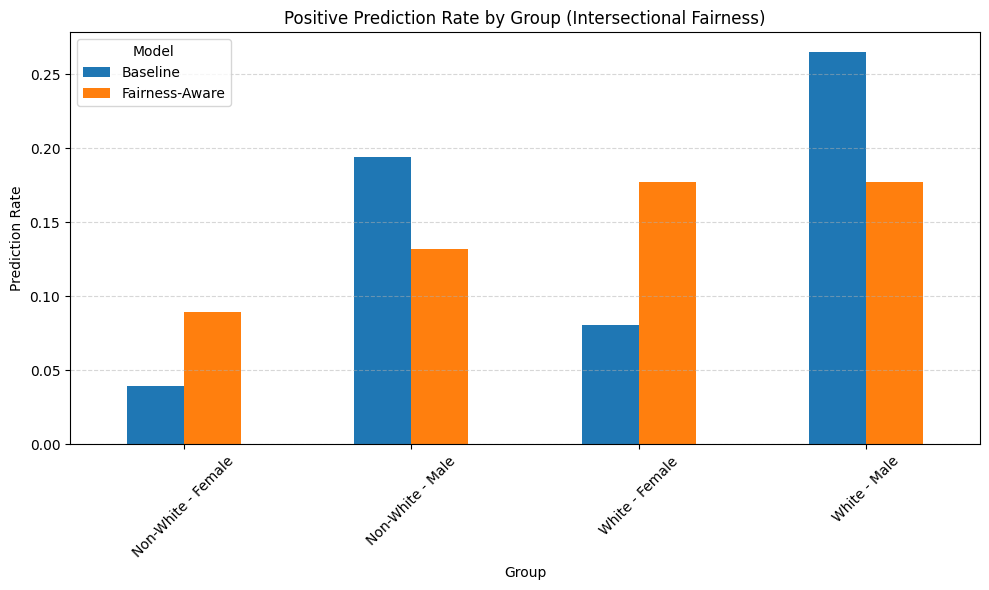

In [23]:
import matplotlib.pyplot as plt

# Group-level mean predictions
group_stats = X_test_copy.groupby('group')[['y_pred_baseline', 'y_pred_fair']].mean()
group_stats.columns = ['Baseline', 'Fairness-Aware']

group_stats.plot(kind='bar', figsize=(10, 6))
plt.title('Positive Prediction Rate by Group (Intersectional Fairness)')
plt.ylabel('Prediction Rate')
plt.xlabel('Group')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


visualization

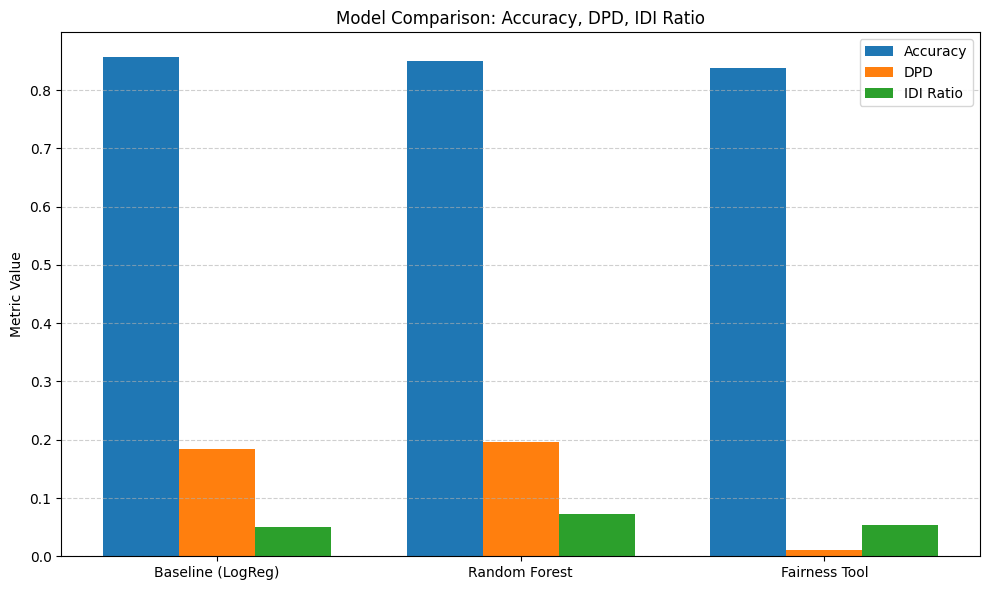

In [24]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Baseline (LogReg)', 'Random Forest', 'Fairness Tool']
accuracy = [acc_logreg, acc_rf, acc_fair]
dpd = [dpd_logreg, dpd_rf, dpd_fair]
idi = [idi_logreg, idi_rf, idi_fair]

x = np.arange(len(models))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, accuracy, width, label='Accuracy')
ax.bar(x, dpd, width, label='DPD')
ax.bar(x + width, idi, width, label='IDI Ratio')

ax.set_ylabel('Metric Value')
ax.set_title('Model Comparison: Accuracy, DPD, IDI Ratio')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



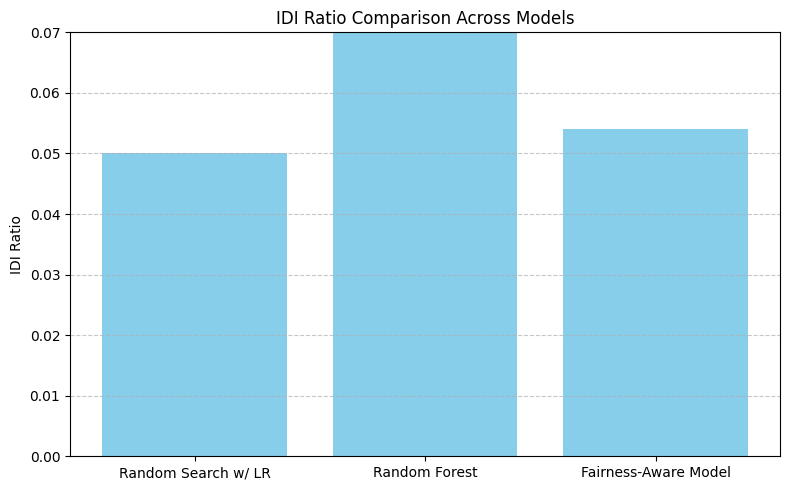

In [26]:
import matplotlib.pyplot as plt

models = ['Random Search w/ LR', 'Random Forest', 'Fairness-Aware Model']

idi_values = [idi_logreg, idi_rf, idi_fair]

plt.figure(figsize=(8, 5))
plt.bar(models, idi_values, color='skyblue')
plt.title('IDI Ratio Comparison Across Models')
plt.ylabel('IDI Ratio')
plt.ylim(0, 0.07)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [29]:
# T test for accuracy
from scipy.stats import ttest_rel

baseline_correct = (y_pred_baseline == y_test).astype(int)
fair_correct = (y_fair_pred == y_test).astype(int)

t_stat, p_val = ttest_rel(baseline_correct, fair_correct)

print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("Statistically significant difference in accuracy")
else:
    print("No statistically significant difference")


T-statistic: 5.1749, p-value: 0.0000
Statistically significant difference in accuracy


In [27]:
# Stat test for baseline
from scipy.stats import chi2_contingency
import numpy as np

# Create contingency table for fairness comparison (baseline vs. fairness model)
contingency_table = np.array([
    [(y_test[(X_test["sex_ Male"] == 1) & (y_pred_baseline == 1)].shape[0]),
     (y_test[(X_test["sex_ Male"] == 1) & (y_pred_baseline == 0)].shape[0])],

    [(y_test[(X_test["sex_ Male"] == 0) & (y_pred_baseline == 1)].shape[0]),
     (y_test[(X_test["sex_ Male"] == 0) & (y_pred_baseline == 0)].shape[0])]
])

# Run Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat:.2f}")
print(f"P-Value: {p_value:.5f}")

if p_value < 0.05:
    print("Statistically Significant Bias Reduction! Reject Null Hypothesis (H₀)")
else:
    print("No Significant Bias Reduction. Fail to Reject Null Hypothesis (H₀)")



Chi-Square Statistic: 304.89
P-Value: 0.00000
Statistically Significant Bias Reduction! Reject Null Hypothesis (H₀)


In [28]:
# stat test for tool
contingency_table_fair = np.array([
    [(y_test[(X_test["sex_ Male"] == 1) & (y_fair_pred == 1)].shape[0]),
     (y_test[(X_test["sex_ Male"] == 1) & (y_fair_pred == 0)].shape[0])],

    [(y_test[(X_test["sex_ Male"] == 0) & (y_fair_pred == 1)].shape[0]),
     (y_test[(X_test["sex_ Male"] == 0) & (y_fair_pred == 0)].shape[0])]
])

chi2_stat_fair, p_value_fair, dof_fair, expected_fair = chi2_contingency(contingency_table_fair)

print(f"\nFairness-Aware Model:")
print(f"Chi-Square Statistic: {chi2_stat_fair:.2f}")
print(f"P-Value: {p_value_fair:.5f}")

if p_value_fair < 0.05:
    print("✅ Still statistically significant difference in predictions by gender")
else:
    print("✅ No statistically significant gender-based prediction bias")



Fairness-Aware Model:
Chi-Square Statistic: 1.27
P-Value: 0.26019
✅ No statistically significant gender-based prediction bias


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train your RF model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_rf_pred = rf_model.predict(X_test_scaled)


In [ ]:
# Convert scaled test set back to DataFrame for gender indexing
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [ ]:
# stat test for RF
from scipy.stats import chi2_contingency
import numpy as np

# Contingency table for Random Forest predictions by gender
rf_contingency = np.array([
    [y_test[(X_test["sex_ Male"] == 1) & (y_rf_pred == 1)].shape[0],
     y_test[(X_test["sex_ Male"] == 1) & (y_rf_pred == 0)].shape[0]],

    [y_test[(X_test["sex_ Male"] == 0) & (y_rf_pred == 1)].shape[0],
     y_test[(X_test["sex_ Male"] == 0) & (y_rf_pred == 0)].shape[0]]
])

# Run Chi-Square test
chi2_rf, p_rf, dof_rf, expected_rf = chi2_contingency(rf_contingency)

print(f"Random Forest Chi-Square: {chi2_rf:.2f}")
print(f"P-Value: {p_rf:.5f}")

if p_rf < 0.05:
    print("Random Forest shows significant gender-based prediction bias")
else:
    print("Random Forest does not show significant gender-based bias")


Random Forest Chi-Square: 320.20
P-Value: 0.00000
✅ Random Forest shows significant gender-based prediction bias
